In [45]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import scipy.special as spc
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

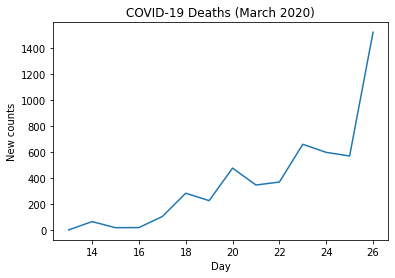

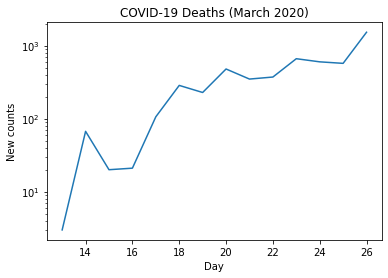

In [46]:
# New York State
days = np.array([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26])
counts = np.array([47, 50, 117, 137, 158, 264, 549, 777, 1255, 1603, 1974, 2635, 3234, 3805, 5327])
# Santa Clara County
#days = np.array([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26])
#counts = np.array([1, 2, 2, 4, 5, 6, 6, 8, 8, 10, 13, 16, 17, 19, 20])
new_counts = np.diff(counts)
days = days[1:]
plt.plot(days, new_counts)
plt.ylabel('New counts')
plt.xlabel('Day')
plt.title('COVID-19 Deaths (March 2020)')
plt.show()
plt.semilogy(days, new_counts)
plt.ylabel('New counts')
plt.xlabel('Day')
plt.title('COVID-19 Deaths (March 2020)')
plt.show()

In [51]:
#gaussian_model = sm.GLM(np.log(new_counts), days, family=sm.families.Gaussian())
gaussian_model = sm.GLM(np.log(new_counts), sm.add_constant(days), family=sm.families.Gaussian())
gaussian_results = gaussian_model.fit()
print(gaussian_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   14
Model:                            GLM   Df Residuals:                       12
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                         0.66457
Method:                          IRLS   Log-Likelihood:                -15.926
Date:                Thu, 01 Oct 2020   Deviance:                       7.9748
Time:                        12:02:46   Pearson chi2:                     7.97
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.0389      1.076     -1.894      0.0

In [53]:
poisson_model = sm.GLM(new_counts, sm.add_constant(days), family=sm.families.Poisson())
poisson_results = poisson_model.fit()
print(poisson_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   14
Model:                            GLM   Df Residuals:                       12
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -412.77
Date:                Thu, 01 Oct 2020   Deviance:                       728.14
Time:                        12:04:48   Pearson chi2:                     691.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4377      0.104      4.204      0.0

In [54]:
nb_model = sm.GLM(new_counts, sm.add_constant(days), family=sm.families.NegativeBinomial())
nb_results = nb_model.fit()
print(nb_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   14
Model:                            GLM   Df Residuals:                       12
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -89.035
Date:                Thu, 01 Oct 2020   Deviance:                       6.4450
Time:                        12:06:34   Pearson chi2:                     4.87
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7555      1.331     -0.567      0.5

Next we'll go over some intuition-building examples with the bootstrap:

In [2]:
def bootstrap_1d(samples, mu, B=1000, plot=True, fnc=np.mean):
    mu_hat = fnc(samples)
    mu_boot = np.zeros(shape=(B,))
    for b in range(B):
        bootstrap_samples = rnd.choice(samples, N)
        mu_boot[b] = fnc(bootstrap_samples)
    if plot:
        low = np.min(mu_boot)
        high = np.max(mu_boot)
        length = high - low
        low, high = low - 0.1 * length, high + 0.1 * length
        plt.hist(mu_boot, bins=np.arange(low, high, 0.05 * length))
        plt.axvline(mu_hat, color='r', linestyle='dashed', linewidth=3)
        plt.axvline(mu, color='g', linestyle='dashed', linewidth=3)
        plt.show()
    return mu_boot

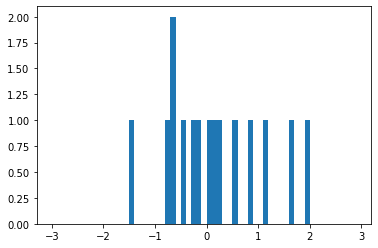

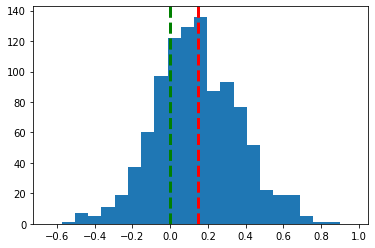

In [12]:
# Mean estimation
# 1: Gaussian
mu = 0.0
sigma = 1.0
N = 15
samples = rnd.normal(mu, sigma, N)
plt.hist(samples, bins=np.arange(-3, 3, .1))
plt.show()
mu_boot = bootstrap_1d(samples, mu, fnc=np.mean)
#print('Estimated stdev: %.3f' % np.std(mu_boot))
#print('True stdev: %.3f' % (sigma / np.sqrt(N)))

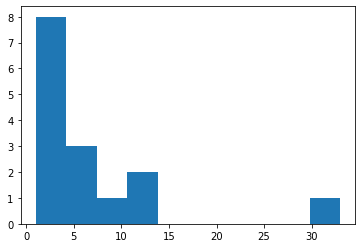

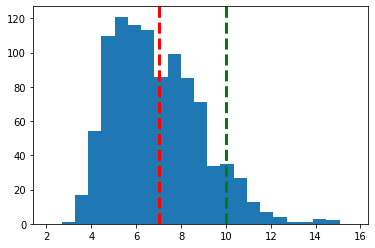

Estimated stdev (bootstrap): 1.974
Estimated stdev (simple) 2.031
True stdev: 2.449


In [29]:
# 2: Geometric
r = 0.1
N = 15
samples = rnd.geometric(r, N)
plt.hist(samples)
plt.show()
mu_boot = bootstrap_1d(samples, 1.0/r)
print('Estimated stdev (bootstrap): %.3f' % np.std(mu_boot))
print('Estimated stdev (simple) %.3f' % (np.std(samples) / np.sqrt(N-1)))
print('True stdev: %.3f' % ((np.sqrt(1-r)/r) / np.sqrt(N)))

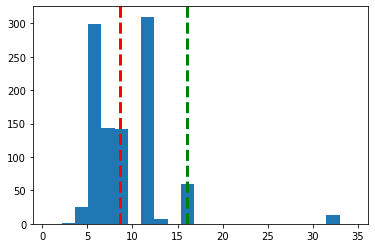

In [30]:
samples_large = rnd.geometric(r, 10000)
#fnc = np.median
#bootstrap_1d(samples, fnc(samples_large), fnc=fnc)
fnc = lambda x : np.quantile(x, 0.8)
bootstrap_1d(samples, fnc(samples_large), fnc=fnc);

In [71]:
def logistic_regression(X, y):
    return LogisticRegression(solver='lbfgs', fit_intercept=False).fit(X, y).coef_[0]


def bootstrap_xy(X, y, w=None, B=1000, fnc=logistic_regression, plot=True):
    d = X.shape[1]
    N = X.shape[0]
    w_hat = fnc(X, y)
    w_boot = np.zeros(shape=(B,d))
    for b in range(B):
        bootstrap_indices = rnd.choice(np.arange(N), N)
        bootstrap_X = X[bootstrap_indices, :]
        bootstrap_y = y[bootstrap_indices]
        w_boot[b,:] = fnc(bootstrap_X, bootstrap_y)
    if plot:
        plt.scatter(w_boot[:,0], w_boot[:,1], c='b')
        plt.scatter(w_hat[0], w_hat[1], c='r', marker='x', s=300)
        if w:
            plt.scatter(w[0], w[1], c='g', marker='x', s=300)
        plt.show()
    return w_boot

[ 2 -1]
[ 1.50424867 -1.02370555]


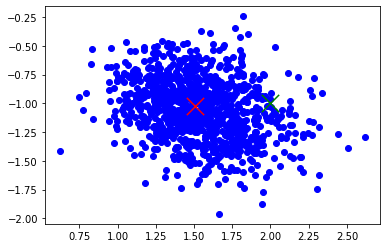

In [42]:
N = 100
d = 2
sigmoid = spc.expit
w = np.array([2, -1])
#w = np.array([1, 2, -1, -2, 1, 1, 1, 1, 1, 1])
X = rnd.randn(N,d)
z = np.sum(X*w, 1)
y = rnd.binomial(1, sigmoid(z))
w_hat = logistic_regression(X, y)
print(w)
print(w_hat)
bootstrap_xy(X, y, w, B=1000);

Finally, let's use the bootstrap to fix the issues with the Poisson model:

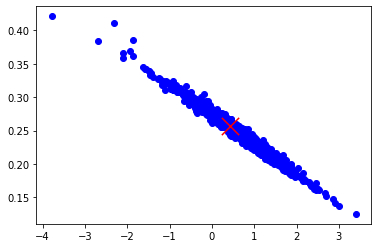

In [79]:
def get_beta(X, y):
    poisson_model = sm.GLM(y, X, family=sm.families.Poisson())
    poisson_results = poisson_model.fit()
    return poisson_results.params # params[0] is intercept term
                                  # params[1] is days term
samples = bootstrap_xy(sm.add_constant(days), new_counts, fnc=get_beta)

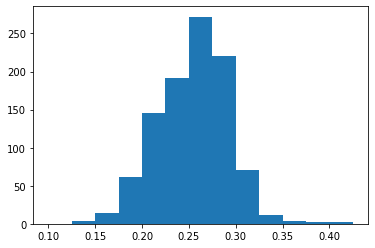

95th percentile: 0.311


In [85]:
plt.hist(samples[:,1], bins=np.arange(0.10, 0.45, 0.025))
plt.show()
print('95th percentile: %.3f' % np.quantile(samples[:,1], 0.95))